# Problem Statement

As the sales manager for "BeerMart", an online beer store in the United States, I want to build a recommendation system (collaborative) for our store, where customers will be recommended the beer that they are most likely to buy. We've collected data about the ratings that the customers have given in the past using which we will build a recommender model.

## Dataset

Beer Dataset 

`Description` - Each record includes a beer's name and the user's name, along with the ratings he/she has given to the beer. All ratings are on a scale from 1 to 5, with 5 being the best rating.

In [1]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from numpy import *

# hide warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# read the dataset
beer = pd.read_csv("beer_data.csv")

In [3]:
# summary of the dataset - no null records, 1 integer, 1 float and 1 object columns
beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
beer_beerid           475984 non-null int64
review_profilename    475884 non-null object
review_overall        475984 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ MB


In [4]:
# head
beer.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [5]:
# describe database
beer.describe()

,beer_beerid,review_overall
count,475984.000000,475984.000000
mean,21660.550611,3.814827
std,21793.437326,0.720411
min,3.000000,0.000000
25%,1716.000000,3.500000
50%,13892.000000,4.000000
75%,39397.000000,4.500000
max,77317.000000,5.000000


In [6]:
# Find null values
beer.isnull().any()

beer_beerid           False
review_profilename     True
review_overall        False
dtype: bool

In [7]:
# Finding the rows having null values
beer.isnull().any(axis=1).sum()

100

In [8]:
# Get the total no. of null values in each column
beer.isnull().sum()

beer_beerid             0
review_profilename    100
review_overall          0
dtype: int64

In [9]:
#Get the percentage of null values in each column
print (round((beer.isnull().sum() * 100/ len(beer)),2).sort_values(ascending=False))

review_profilename    0.02
review_overall        0.00
beer_beerid           0.00
dtype: float64


Since the percentage of null values is very less, that can be dropped

In [10]:
# filter null values
beer = beer[~beer.review_profilename.isnull()]
beer.shape

(475884, 3)

In [11]:
# Finding duplicate records
len(beer[beer.duplicated()].index)

580

In [12]:
# Let's drop the duplicates and retain the first row
beer.drop_duplicates(keep = 'first', inplace = True)

In [13]:
beer.duplicated().sum()

0

In [14]:
beer.shape

(475304, 3)

## 1. Data Preparation

`Choose only those beers that have at least N number of reviews.`

In [15]:
# Grouping data by ratings
beer_ratings = beer.groupby('beer_beerid').review_overall.count()

In [16]:
beer_reviews = pd.DataFrame(beer_ratings).reset_index()
beer_reviews.columns = ['beer_beerid','Ratings']

In [17]:
beer_reviews.count()

beer_beerid    40304
Ratings        40304
dtype: int64

In [18]:
# Grouping data by name
beer_names = beer.groupby('review_profilename').review_overall.count()
beer_names.head()

review_profilename
0110x011       35
01Ryan10        1
03SVTCobra      1
04101Brewer     1
05Harley       41
Name: review_overall, dtype: int64

In [19]:
beer_profiles = pd.DataFrame(beer_names).reset_index()
beer_profiles.columns = ['review_profilename','reviews']

In [20]:
beer_profiles.count()

review_profilename    22497
reviews               22497
dtype: int64

### Data Analysis

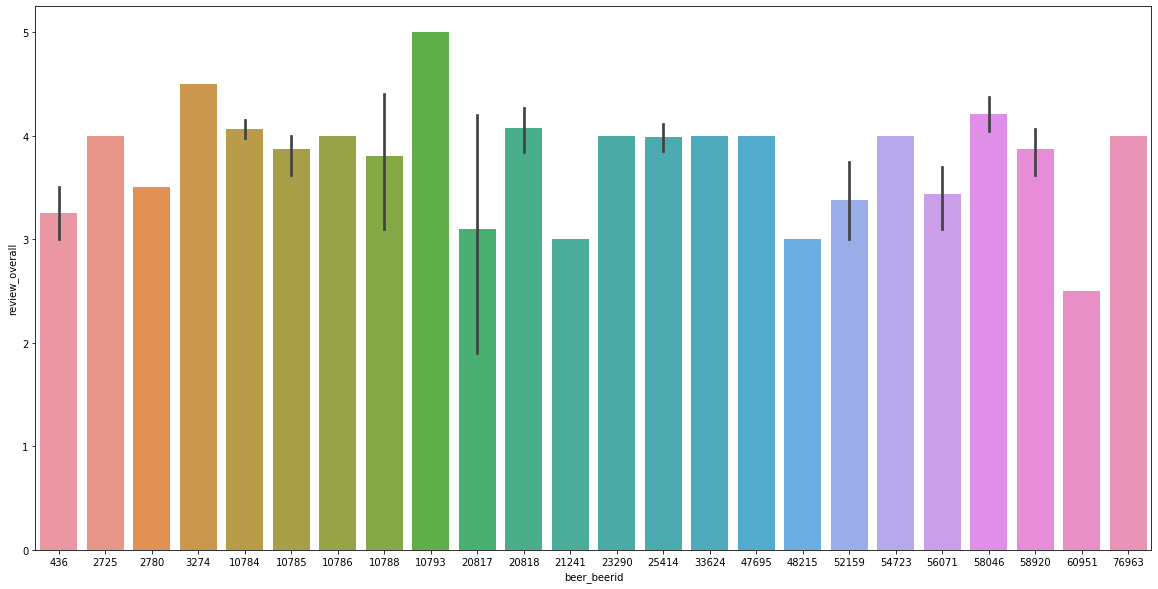

In [21]:
# analyse reviews by index
plt.figure(figsize=(20, 10))
sns.barplot(x=beer[0:250].beer_beerid, y=beer[0:250].review_overall)
plt.show()

In [22]:
beer.beer_beerid.nunique()

40304

In [23]:
beer.review_profilename.nunique()

22497

In [24]:
# No of Reviews
beer_reviews.Ratings.value_counts().count()

442

`There are 442 reviews, so we could take beers that have more than 5% of the reviews which is 5% of 442.  We will take 25 as the minimum number of reviews for any given beer`

In [25]:
# filter records to have only those that have 25 or more reviews
beer_all_reviews = beer_reviews.loc[(beer_reviews['Ratings'] >= 25)].beer_beerid.to_frame('beer_beerid')
beer_all_profiles = beer_profiles.loc[(beer_profiles['reviews'] >= 25)].review_profilename.to_frame('review_profilename')

In [26]:
beer_tmp = pd.merge(beer, beer_all_reviews, how='inner', on='beer_beerid')
beer_final = pd.merge(beer_tmp, beer_all_profiles, how='inner', on='review_profilename')

In [27]:
beer_final.shape

(284696, 3)

In [28]:
beer_final.head()

,beer_beerid,review_profilename,review_overall
0,436,Brent,3.0
1,10784,Brent,4.0
2,10785,Brent,4.0
3,16074,Brent,4.0
4,33644,Brent,4.0


## 2. Data Exploration

#### 1. Unique value of ratings

Unique value of Ratings:  9


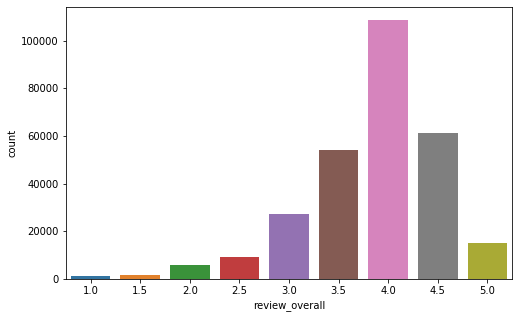

In [29]:
# Unique value of ratings
print("Unique value of Ratings: ",beer_final.review_overall.nunique())
plt.figure(figsize=(8, 5))
sns.countplot('review_overall', data=beer_final)
plt.show()

#### 2. Visualizing the rating values

#### Average Beer Ratings

Average Beer rating is  3.78


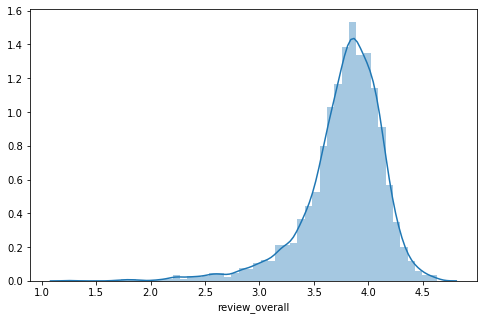

In [30]:
# Average Beer Ratings
print("Average Beer rating is ",round(beer_final.groupby('beer_beerid').review_overall.mean().mean(),2))
plt.figure(figsize=(8, 5))
sns.distplot(beer_final.groupby('beer_beerid').review_overall.mean())
plt.show()

#### Average User Ratings

Average User rating is  3.86


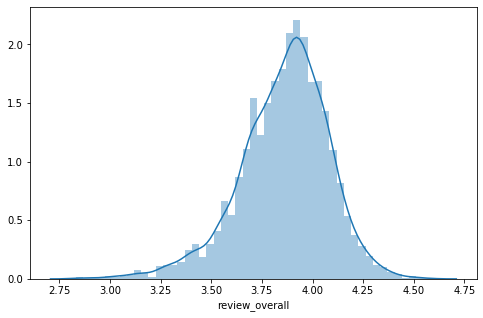

In [31]:
# Average User Ratings
print("Average User rating is ",round(beer_final.groupby('review_profilename').review_overall.mean().mean(),2))
plt.figure(figsize=(8, 5))
sns.distplot(beer_final.groupby('review_profilename').review_overall.mean())
plt.show()

#### The average number of ratings given to the beers

Average no of ratings given to beers is  79.32


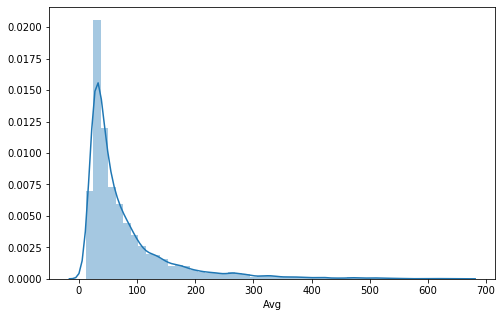

In [32]:
# The average number of ratings given to the beers
beer_ratings_avg = beer_final.groupby('beer_beerid').review_overall.count()
beer_reviews_avg = pd.DataFrame(beer_ratings_avg).reset_index()
beer_reviews_avg.columns = ['beer_beerid','Avg']

print("Average no of ratings given to beers is ",round(beer_reviews_avg.groupby('beer_beerid').Avg.mean().mean(),2))
plt.figure(figsize=(8, 5))
sns.distplot(beer_reviews_avg.groupby('beer_beerid').Avg.mean())
plt.show()

#### The average number of ratings given by the users

Average no of ratings given to beers is  79.61


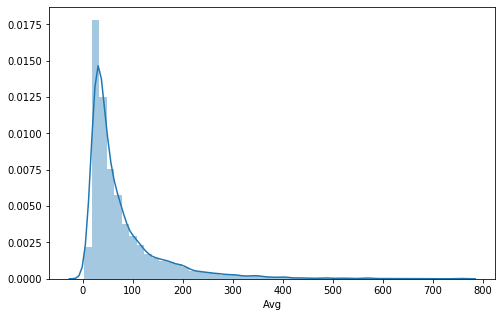

In [33]:
# The average number of ratings given by the users
beer_names_avg = beer_final.groupby('review_profilename').review_overall.count()
beer_profiles_avg = pd.DataFrame(beer_names_avg).reset_index()
beer_profiles_avg.columns = ['review_profilename','Avg']

print("Average no of ratings given to beers is ",round(beer_profiles_avg.groupby('review_profilename').Avg.mean().mean(),2))
plt.figure(figsize=(8, 5))
sns.distplot(beer_profiles_avg.groupby('review_profilename').Avg.mean())
plt.show()

## 3. Recommendation Models

#### 1. Divide your data into training and testing dataset.

In [34]:
# Divide your data into training and testing dataset.
train, test = train_test_split(beer_final, train_size=0.70,test_size=0.30, random_state=42)

In [35]:
print(train.shape)
print(test.shape)

(199287, 3)
(85409, 3)


In [36]:
test.head()

,beer_beerid,review_profilename,review_overall
212535,22381,rembrant,4.0
77738,631,maxpower,3.0
87726,21690,TheFightfan1,5.0
77297,236,HappyHourHero,4.0
207503,52128,billybob,4.5


#### 2. Build user-based and item-based models.

In [37]:
# pivot ratings into beer features
beer_features = train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [38]:
beer_features.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0

In [39]:
# Copying train and test data
dummy_train = train.copy()
dummy_test = test.copy()

In [40]:
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x >= 1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x >= 1 else 0)

In [41]:
# The beers that are not rated by users are marked 1 for prediction. 
dummy_train = dummy_train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers that are not rated by users is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [42]:
dummy_train.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0

In [43]:
dummy_test.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0

### User Similarity Matrix
### Using Cosine Similarity

In [44]:
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(beer_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.03788595 0.         ... 0.         0.07152776 0.        ]
 [0.03788595 1.         0.075372   ... 0.         0.06272381 0.        ]
 [0.         0.075372   1.         ... 0.         0.03172024 0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.07152776 0.06272381 0.03172024 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [45]:
user_correlation.shape

(3575, 3575)

### Using adjusted Cosine
### Here, not removing the NaN values and calculating the mean only for the beers rated by the user

In [46]:
beer_n_features = train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [47]:
beer_n_features.tail()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
zoolzoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,

### Normalising the rating of the beer for each user around 0 mean

In [48]:
mean = np.nanmean(beer_n_features, axis=1)
df_subtracted = (beer_n_features.T-mean).T

In [49]:
df_subtracted.tail()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
zoolzoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN

### Finding Cosine similarity

In [50]:
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.02926937  0.         ...  0.          0.05165534
   0.        ]
 [-0.02926937  1.         -0.0124139  ...  0.          0.01213332
   0.        ]
 [ 0.         -0.0124139   1.         ...  0.          0.00462005
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.05165534  0.01213332  0.00462005 ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


### Prediction

In [51]:
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.05165534,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.01213332,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.00462005,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05165534, 0.01213332, 0.00462005, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

`Rating predicted by the user (for beers rated as well as non rated) is the weighted sum of correlation with the beer rating (as present in the rating dataset). `

In [52]:
user_predicted_ratings = np.dot(user_correlation, beer_n_features.fillna(0))
user_predicted_ratings

array([[0.88980454, 2.37136865, 2.04217193, ..., 2.22547047, 1.93016549,
        1.17992678],
       [2.60067693, 4.4848318 , 3.53001497, ..., 4.92746483, 2.57994996,
        1.7196961 ],
       [1.02790381, 1.47182216, 1.24154132, ..., 1.44620971, 0.53020566,
        1.97673849],
       ...,
       [5.08209053, 8.33387249, 4.26122086, ..., 3.32154643, 2.07518845,
        2.60683438],
       [3.36855814, 6.59760778, 4.57840842, ..., 5.56460952, 1.79473733,
        2.96926303],
       [2.88661525, 5.50940783, 4.2470835 , ..., 1.73886595, 0.64752718,
        1.96102639]])

In [53]:
user_predicted_ratings.shape

(3575, 3589)

Since we are interested only in the beers not rated by the user, we will ignore the beers rated by the user by making it zero. 

In [54]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.889805,2.371369,2.042172,0.096343,2.059964,0.118114,0.102375,0.514505,0.676616,1.706384,1.221663,0.637090,5.722876,2.304541,0.827935,6.533283,6.753672,2.045795,6.392119,0.399382,0.258012,0.477901,0.556757,0.238213,1.776934,2.603601,4.651612,5.049105,2.171435,0.185922,0.991438,0.403910,0.053650,6.859422,2.089290,0.373607,1.568119,0.744289,1.423540,0.203329,1.072398,2.741091,0.976778,3.367169,8.449002,2.850098,6.566361,8.220499,0.850936,1.875215,0.334875,2.887360,0.944469,5.108552,5.303727,4.931442,4.673527,0.047965,1.828742,1.116588,0.492667,0.636350,0.485709,1.098246,0.440504,0.709097,5.716011,7.330660,3.205711,1.132523,1.520746,0.937283,0.827002,1.280815,1.769073,1.161209,5.724724,4.331501,0.630592,3.237728,2.296955,4.183112,0.215250,0.269837,0.672898,3.259849,2.589680,0.704964,0.299458,2.091723,0.029616,0.942925,0.414236,0.271007,0.295209,1.527273,0.616606,2.734911,2.557288,1.581271,0.941604,0.581599,0.606310,0.221103,4.222731,0.418113,3.778848,5.874963,3.765226,0.666348,1.885190,3.255432,1.4

### Finding the top 5 recommendation for the user 1 

In [55]:
user_final_rating.iloc[1].sort_values(ascending=False)[0:5]

beer_beerid
1093     23.946381
17112    21.916093
1904     21.596054
4083     21.311367
412      21.137489
Name: 05Harley, dtype: float64

### Item based similarity
Using correlation

In [56]:
beer_n_features = train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

beer_n_features.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz,57md,7ways,86MonteSS,86sportster883,99bottles,9InchNails,ABOWMan,AChamberlain,ADR,ADZA,AEK,AJacob81,AKBelgianBeast,ALESwhatCURESya,ATLbeerDog,ATPete,AWolfAtTheDoor,AaronHomoya,AaronRed,Abita45,Absumaster,AdamBear,AdamGarcia,AdmiralDiaz,Admiraldinty,Aenema,AgentMunky,AgentZero,AgingWarrior,Agold,Ahhdball,Aiptasia,AlCaponeJunior,AleWatcher,AlexJ,AlexLMS,Alieniloquium,Alkey,AllThingsNinja,AltBock,Amalak,AmberMan22,AmericanGothic,AndoBrew,Andreji,Andy,AndyAvalanche,Anthony1,Antilochus,Applesauce1,Arbitrator,Arenbeer,Arithmeticus,ArrogantB,ArrogantDeadGuy,Asgeirr,AtLagerHeads,Atlas1,Atricapilla,Atron67,AtrumAnimus,AudioGilz,Augustiner719,Auracom,AustinBeerLvr,Avagadro,Avantyawn,Avryle,AwYeh,Axic10,AylwinForbes,Azurescens,B967ierhunter177,BB1313,BBM,BBP,BDIMike,BDJake,BDLbrewster,BDTyre,BEERMILER12,BEERchitect,BMan1113VR,BMoldy,BMoney575,BSF,BTPete,BWH3,BWMKappaSig,BZero007,Backer2004,BadBadger,BadRockBeer,Bagman007,Baileyuk,BamaBeerBuff,Bananaman,BanditTA,Barraclou,BarrelO,BarryMFBurton,BarrytheBear,Bcant,BeTheBall,BeaBeerWife,BeanBone,BearJohnson,BeardedBoffin,BeardedRiker,BearsOnAcid,Beastdog75,Beaver13,BedetheVenerable,Beefeater57,BeefyMee,Beejay,BeenJammin,Beer4Baltimore,BeerAdvocate,BeerAmbassador,BeerAndBourbon,BeerAngel,BeerBeing,BeerBelcher,BeerBob,BeerBuckeye,BeerBuilder,BeerCon5,BeerDawgs,BeerFMAndy,BeerFink,BeerForMuscle,BeerGodz,BeerImmediately,BeerIsland,BeerLover99,BeerMan7777777,BeerManDan,BeerMansGirl,BeerMark,BeerNemesis,BeerNinja007,BeerNutta,BeerPanther,BeerPhan86,BeerResearcher,BeerRun13,BeerSingh,BeerSox,BeerTaster,BeerTruth,BeerZack,Beerandraiderfan,Beerbluesbiology,Beerbuddha,Beerenauslese,BeerisfoodLLC,Beerisheaven,Beernoisseur,Beersignal,Beertracker,Beerwolf17,Beeryce,Beerzebub,BelgiumBill,Bendurgin,BennyL1,BerkeleyBeerMan,BetterDarker,BevMoAndrew,Bfarr,BierFan,BierManVA,BierReise,BieresDesMoines,Bierguy5,Bierman9,Bierschenker,Big78CJ,BigBry,BigDaddyWil,BigIrishman,BigJTrucker,BigJim5021,BigMcLargeHuge,BigMike,BigPlay1824,BigRedN,Biggness,Bighuge,BilbosNuts,Billolick,BillyB,BillyBoysPie,BillyBrew,BirdFlu,Birdiebeagle,Biscuit033,BitteBier,Bitterbill,Bitterman,BlackAngus,BlackBearForge,BlackHaddock,Blakaeris,Blanco,BlindPig,BlueLawyer,Bmoyer0301,BobZ,Bockrules,Boilermaker88,BoitSansSoif,Bonhoeffer,Bonis,Bookseeb,Boppar,Boto,Bouleboubier,Bourre,Bowdoinbeerboy,Brabander,Brad007,BradBLR,BradLikesBrew,BranfordBound,Braudog,Brenden,Brent,BretSikkink,Brew33,BrewCrew2010,BrewMaster,BrewMaven,BrewMonkey,BrewSomerville,...,tbrown4,tburkhart,tchenery,tdawgydog,tdm168,techdiver,techfed87,tedpeer,tedsox31,teg8612,tempest,tendermorsel,teromous,terrabyte,tesguino,tewaris,texashammer,tfsimpkins,tgbljb,thagr81us,thain709,thartman,the42ndtourist,thebeerdoctor,theboozecruise,thebrood1987,thecarster1,thechamp,thedoubler55,thedrewski86,theformula,theghost3,thegodfather2701,thehyperduck,thekanna,thekevlarkid,thelagerheads,theopholis,theozag,thepeter,thequeen711,therica,thespaceman,thetomG,thierrynantes,thirdeye11,thirtysixbelow,thryn,tiger88,tigerpaws,tigg924,timbro81,timtheenchanta,timtim,tippebrewcrew2,tito42,titosupertramp,tjd112,tjkinate,tjsdomer2,tjthresh,tlazaroff,tmitch75,tmoneyba,tobelerone,todd1,tomthumbsblues,tone77,tonistruth,tony223366,toolbrew,tpd975,tr4nc3d,trackstar1043,translucent,trappistlover,travduke,travolta,trbergman,treehugger02010,trep,treque,trevorjn06,trevorwideman,treyrab,tronester,troutmask96,trumick,trxxpaxxs,tsauce2,tubacharlie,tubbfan,tugdriver7,turbine2475,tvv375ia,tweeder263,twelvsies,twi1609372,twiggamortis420,twilight,tykees88,tytoanderso,tzieser,u2carew,udubdawg,uglyguy,ujsplace,ultralarry2006,ummswimmin,umustdrink,unclederby,unclejimbay,unklesyd,uno99,urwithdave,usualpulp,uustal,uwmgdman,vacax,vancurly,vande,vandemonian,vanrassel,vdread,veech,veggiemafia,velkyal,velosuds,vette2006c5r,vfgccp,vickersspitfire,villainchiwwin,vitesse,vkv822,vrazionale,vt

In [57]:
# Normalising the rating for each beer
mean = np.nanmean(beer_n_features, axis=1)
df_subtracted = (beer_n_features.T-mean).T

In [58]:
df_subtracted.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz,57md,7ways,86MonteSS,86sportster883,99bottles,9InchNails,ABOWMan,AChamberlain,ADR,ADZA,AEK,AJacob81,AKBelgianBeast,ALESwhatCURESya,ATLbeerDog,ATPete,AWolfAtTheDoor,AaronHomoya,AaronRed,Abita45,Absumaster,AdamBear,AdamGarcia,AdmiralDiaz,Admiraldinty,Aenema,AgentMunky,AgentZero,AgingWarrior,Agold,Ahhdball,Aiptasia,AlCaponeJunior,AleWatcher,AlexJ,AlexLMS,Alieniloquium,Alkey,AllThingsNinja,AltBock,Amalak,AmberMan22,AmericanGothic,AndoBrew,Andreji,Andy,AndyAvalanche,Anthony1,Antilochus,Applesauce1,Arbitrator,Arenbeer,Arithmeticus,ArrogantB,ArrogantDeadGuy,Asgeirr,AtLagerHeads,Atlas1,Atricapilla,Atron67,AtrumAnimus,AudioGilz,Augustiner719,Auracom,AustinBeerLvr,Avagadro,Avantyawn,Avryle,AwYeh,Axic10,AylwinForbes,Azurescens,B967ierhunter177,BB1313,BBM,BBP,BDIMike,BDJake,BDLbrewster,BDTyre,BEERMILER12,BEERchitect,BMan1113VR,BMoldy,BMoney575,BSF,BTPete,BWH3,BWMKappaSig,BZero007,Backer2004,BadBadger,BadRockBeer,Bagman007,Baileyuk,BamaBeerBuff,Bananaman,BanditTA,Barraclou,BarrelO,BarryMFBurton,BarrytheBear,Bcant,BeTheBall,BeaBeerWife,BeanBone,BearJohnson,BeardedBoffin,BeardedRiker,BearsOnAcid,Beastdog75,Beaver13,BedetheVenerable,Beefeater57,BeefyMee,Beejay,BeenJammin,Beer4Baltimore,BeerAdvocate,BeerAmbassador,BeerAndBourbon,BeerAngel,BeerBeing,BeerBelcher,BeerBob,BeerBuckeye,BeerBuilder,BeerCon5,BeerDawgs,BeerFMAndy,BeerFink,BeerForMuscle,BeerGodz,BeerImmediately,BeerIsland,BeerLover99,BeerMan7777777,BeerManDan,BeerMansGirl,BeerMark,BeerNemesis,BeerNinja007,BeerNutta,BeerPanther,BeerPhan86,BeerResearcher,BeerRun13,BeerSingh,BeerSox,BeerTaster,BeerTruth,BeerZack,Beerandraiderfan,Beerbluesbiology,Beerbuddha,Beerenauslese,BeerisfoodLLC,Beerisheaven,Beernoisseur,Beersignal,Beertracker,Beerwolf17,Beeryce,Beerzebub,BelgiumBill,Bendurgin,BennyL1,BerkeleyBeerMan,BetterDarker,BevMoAndrew,Bfarr,BierFan,BierManVA,BierReise,BieresDesMoines,Bierguy5,Bierman9,Bierschenker,Big78CJ,BigBry,BigDaddyWil,BigIrishman,BigJTrucker,BigJim5021,BigMcLargeHuge,BigMike,BigPlay1824,BigRedN,Biggness,Bighuge,BilbosNuts,Billolick,BillyB,BillyBoysPie,BillyBrew,BirdFlu,Birdiebeagle,Biscuit033,BitteBier,Bitterbill,Bitterman,BlackAngus,BlackBearForge,BlackHaddock,Blakaeris,Blanco,BlindPig,BlueLawyer,Bmoyer0301,BobZ,Bockrules,Boilermaker88,BoitSansSoif,Bonhoeffer,Bonis,Bookseeb,Boppar,Boto,Bouleboubier,Bourre,Bowdoinbeerboy,Brabander,Brad007,BradBLR,BradLikesBrew,BranfordBound,Braudog,Brenden,Brent,BretSikkink,Brew33,BrewCrew2010,BrewMaster,BrewMaven,BrewMonkey,BrewSomerville,...,tbrown4,tburkhart,tchenery,tdawgydog,tdm168,techdiver,techfed87,tedpeer,tedsox31,teg8612,tempest,tendermorsel,teromous,terrabyte,tesguino,tewaris,texashammer,tfsimpkins,tgbljb,thagr81us,thain709,thartman,the42ndtourist,thebeerdoctor,theboozecruise,thebrood1987,thecarster1,thechamp,thedoubler55,thedrewski86,theformula,theghost3,thegodfather2701,thehyperduck,thekanna,thekevlarkid,thelagerheads,theopholis,theozag,thepeter,thequeen711,therica,thespaceman,thetomG,thierrynantes,thirdeye11,thirtysixbelow,thryn,tiger88,tigerpaws,tigg924,timbro81,timtheenchanta,timtim,tippebrewcrew2,tito42,titosupertramp,tjd112,tjkinate,tjsdomer2,tjthresh,tlazaroff,tmitch75,tmoneyba,tobelerone,todd1,tomthumbsblues,tone77,tonistruth,tony223366,toolbrew,tpd975,tr4nc3d,trackstar1043,translucent,trappistlover,travduke,travolta,trbergman,treehugger02010,trep,treque,trevorjn06,trevorwideman,treyrab,tronester,troutmask96,trumick,trxxpaxxs,tsauce2,tubacharlie,tubbfan,tugdriver7,turbine2475,tvv375ia,tweeder263,twelvsies,twi1609372,twiggamortis420,twilight,tykees88,tytoanderso,tzieser,u2carew,udubdawg,uglyguy,ujsplace,ultralarry2006,ummswimmin,umustdrink,unclederby,unclejimbay,unklesyd,uno99,urwithdave,usualpulp,uustal,uwmgdman,vacax,vancurly,vande,vandemonian,vanrassel,vdread,veech,veggiemafia,velkyal,velosuds,vette2006c5r,vfgccp,vickersspitfire,villainchiwwin,vitesse,vkv822,vrazionale,vt

Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value. 

In [59]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00 -2.21091566e-02  7.75629334e-02 ...  3.26291683e-02
  -6.24737533e-04  0.00000000e+00]
 [-2.21091566e-02  1.00000000e+00  3.05146998e-03 ...  2.84016219e-03
   6.15168057e-02 -9.25247549e-03]
 [ 7.75629334e-02  3.05146998e-03  1.00000000e+00 ... -7.13802522e-04
   0.00000000e+00  3.34732353e-02]
 ...
 [ 3.26291683e-02  2.84016219e-03 -7.13802522e-04 ...  1.00000000e+00
  -3.08437923e-03 -1.35082853e-02]
 [-6.24737533e-04  6.15168057e-02  0.00000000e+00 ... -3.08437923e-03
   1.00000000e+00  3.31047960e-03]
 [ 0.00000000e+00 -9.25247549e-03  3.34732353e-02 ... -1.35082853e-02
   3.31047960e-03  1.00000000e+00]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [60]:
item_correlation[item_correlation < 0] = 0
item_correlation

array([[1.        , 0.        , 0.07756293, ..., 0.03262917, 0.        ,
        0.        ],
       [0.        , 1.        , 0.00305147, ..., 0.00284016, 0.06151681,
        0.        ],
       [0.07756293, 0.00305147, 1.        , ..., 0.        , 0.        ,
        0.03347324],
       ...,
       [0.03262917, 0.00284016, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.06151681, 0.        , ..., 0.        , 1.        ,
        0.00331048],
       [0.        , 0.        , 0.03347324, ..., 0.        , 0.00331048,
        1.        ]])

### Prediction

In [61]:
item_predicted_ratings = np.dot((beer_n_features.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.39652838, 0.94105859, 0.38652236, ..., 1.03492554, 1.90360443,
        1.80583512],
       [0.14458061, 1.27198439, 0.98717173, ..., 0.58780978, 2.70223707,
        0.77693015],
       [0.3486735 , 1.00268452, 1.08719099, ..., 0.69445126, 2.67782631,
        1.60071643],
       ...,
       [1.41369002, 1.12220752, 1.8151756 , ..., 1.17272138, 1.05700519,
        2.19313925],
       [2.26726298, 1.58003183, 1.83526661, ..., 1.160856  , 0.82206598,
        2.07813814],
       [1.10489528, 0.87331748, 1.1879165 , ..., 0.16428606, 0.43664828,
        0.89123285]])

In [62]:
item_predicted_ratings.shape

(3575, 3589)

In [63]:
dummy_train.shape

(3575, 3589)

### Filtering the rating only for the beers not rated by the user for recommendation

In [64]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.396528,0.941059,0.386522,0.458851,0.628877,1.272702,0.375564,0.925555,1.349595,0.501750,1.136086,0.435219,1.431000,0.817835,0.735156,1.583049,1.412717,0.570012,0.972735,1.151818,0.424482,1.365304,1.782104,1.268200,1.820272,1.145364,0.419700,1.164511,0.888920,0.271248,0.678109,1.015039,0.781014,1.049142,0.824495,0.627091,0.594398,0.904845,0.684701,0.446005,1.077386,1.094663,0.549513,1.854109,1.252620,1.061874,1.121298,1.456577,0.327122,1.171215,1.477339,1.232977,1.295721,1.214432,0.998663,0.653013,1.127176,0.083910,1.324789,1.276019,1.046034,0.881335,0.183325,0.756517,1.126523,0.553583,1.538219,0.825336,0.791284,0.398149,0.924621,1.281046,0.479699,0.925177,1.063769,0.393070,0.435410,1.468776,1.085177,0.345360,0.838630,0.836064,0.493589,0.413123,0.879389,1.450717,1.119526,1.387386,1.291513,1.109289,0.351713,0.629319,0.604011,0.357149,0.639961,0.899037,0.692499,1.335417,1.517233,0.851006,1.146708,1.723196,1.162526,0.180129,0.741808,0.902518,1.571972,1.343381,1.761007,0.755051,1.456042,0.554394,1.0

### Top 5 prediction for the user -1

In [65]:
item_final_rating.iloc[1].sort_values(ascending=False)[0:5]

beer_beerid
51116    3.454962
34363    3.155755
999      3.128435
46749    3.047086
8388     3.000397
Name: 05Harley, dtype: float64

#### 3. Determine how similar the first 10 users are to each other and visualise it.

In [66]:
# First 10 users
top_10_users = user_correlation

def largest_indices(ary, n):
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

similar_users = largest_indices(top_10_users, 10)

for i in list(similar_users):
     list_users = beer_n_features.columns.get_values()[i]

print(list_users)

['eclaycamp' 'ejimhof' 'dual1246' 'ebby82' 'eat' 'dyan' 'dwarbi'
 'dukedevil0' 'dudecandle' 'blackcompg']


In [67]:
user_cor = df_subtracted.iloc[:,list(similar_users[0])].corr()
user_cor

review_profilename,eclaycamp,ejimhof,dual1246,ebby82,eat,dyan,dwarbi,dukedevil0,dudecandle,blackcompg
review_profilename,,,,,,,,,,
eclaycamp,1.000000,NaN,NaN,NaN,-1.000000,-0.934917,NaN,NaN,NaN,NaN
ejimhof,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
dual1246,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ebby82,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
eat,-1.000000,NaN,NaN,NaN,1.000000,0.231524,NaN,-0.345785,NaN,NaN
dyan,-0.934917,1.0,NaN,NaN,0.231524,1.000000,-1.0,0.687207,1.0,NaN
dwarbi,NaN,NaN,NaN,NaN,NaN,-1.000000,1.0,NaN,NaN,NaN
dukedevil0,NaN,NaN,NaN,NaN,-0.345785,0.687207,NaN,1.000000,1.0,NaN
dudecandle,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,1.0,NaN


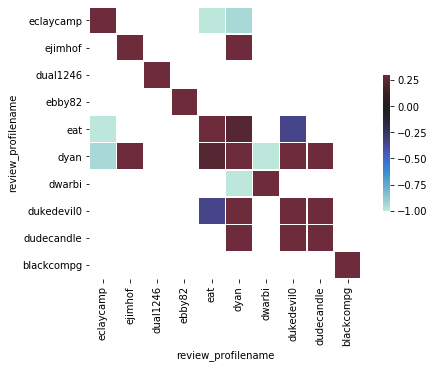

In [68]:
# Visualising similarity
plt.figure(figsize=(8, 5))
sns.heatmap(user_cor,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

These users have some correlation between them. `eat` and `eclaycamp`, `dyan` and `dwarbi` are highly positively correlated, and hence they should have higher similarities.

#### 4. Compute and visualise the similarity between the first 10 beers

In [69]:
# First 10 items
top_10_items = item_correlation

def largest_indices(ary, n):
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

similar_items = largest_indices(top_10_items, 10)

for i in list(similar_items):
     list_items = beer_n_features.T.columns.get_values()[i]

print(list_items)

[35984 36179 36198 36028 35732 35925 35924 35805 35741 75086]


In [70]:
item_cor = df_subtracted.iloc[list(similar_items[0]),:].T.corr()
item_cor

beer_beerid,35984,36179,36198,36028,35732,35925,35924,35805,35741,75086
beer_beerid,,,,,,,,,,
35984,1.000000,NaN,NaN,NaN,NaN,-0.944911,NaN,NaN,NaN,NaN
36179,NaN,1.000000,NaN,NaN,NaN,NaN,0.184115,0.500000,NaN,0.866025
36198,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
36028,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,0.301511,-1.0,NaN
35732,NaN,NaN,NaN,-1.000000,1.000000,0.000000,-0.500000,NaN,1.0,0.594089
35925,-0.944911,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN
35924,NaN,0.184115,NaN,NaN,-0.500000,NaN,1.000000,NaN,NaN,NaN
35805,NaN,0.500000,1.0,0.301511,NaN,NaN,NaN,1.000000,NaN,NaN
35741,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,1.0,NaN


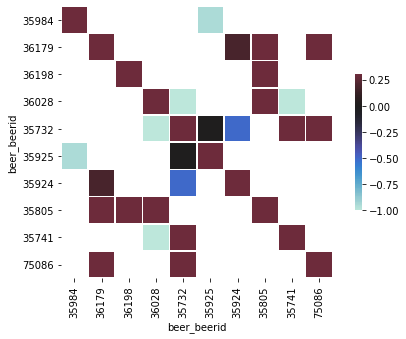

In [71]:
# Visualising similarity
plt.figure(figsize=(8, 5))
sns.heatmap(item_cor,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The items `28305` and `28318`, `28577` and `28305`, `28385` and `28296` are highly positively correlated 

### Evaluation

#### 5. Compare the performance of the two models using test data and suggest the one that should be deployed

In [72]:
# Using User Similarity
test_beer_features = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[ 1.          0.          0.         ...  0.00137287  0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.         -0.01926274
   0.        ]
 ...
 [ 0.00137287  0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.         -0.01926274 ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [73]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_beer_features.fillna(0))
test_user_predicted_ratings

array([[0.        , 0.15024958, 0.07577773, ..., 0.24470788, 0.00866614,
        0.0719312 ],
       [0.08668369, 0.39412809, 0.05215277, ..., 0.        , 0.        ,
        0.08259127],
       [0.01476402, 0.21137262, 0.27633764, ..., 0.04848743, 0.        ,
        0.        ],
       ...,
       [0.13173906, 1.42815343, 1.08243111, ..., 0.90599684, 0.45441504,
        0.10754829],
       [0.91125215, 2.00813038, 1.16786159, ..., 1.23264252, 0.5624823 ,
        0.40987321],
       [0.18140885, 0.05459229, 0.04534093, ..., 0.01678859, 0.05855271,
        0.45807373]])

### Doing prediction for the beers rated by the user

In [74]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [75]:
test_user_final_rating.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Calculating the RMSE for only the beers rated by user. For  RMSE, normalising the rating to (1,5) range. 

In [76]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [77]:
test_ = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [78]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [79]:
# RMSE for User based
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.733078554334754


Using User similarity, the RMSE is `1.733`

In [80]:
# Using Item Similarity
test_beer_features = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation < 0]=0

In [81]:
test_item_correlation.shape

(3588, 3588)

In [82]:
test_beer_features.shape

(3588, 3575)

In [83]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

beer_beerid,5,6,7,9,10,11,12,14,15,17,19,23,30,31,32,33,34,36,39,50,52,54,55,56,58,59,61,63,65,66,67,69,72,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,97,99,100,101,102,103,104,106,108,111,114,115,116,117,120,125,129,131,132,133,134,135,137,138,139,140,141,142,145,146,147,148,151,152,153,155,156,157,158,159,161,171,176,178,179,181,182,184,185,186,188,192,193,194,195,196,197,198,199,202,204,205,206,209,213,214,217,219,221,222,224,225,226,228,229,230,231,232,233,234,235,236,237,243,244,245,246,248,255,259,260,262,263,264,266,270,271,272,273,276,279,280,282,283,286,287,288,289,290,291,292,293,295,296,297,298,299,305,307,310,311,312,313,314,318,319,320,321,327,329,330,331,332,336,340,341,345,347,353,354,355,356,357,358,361,362,363,364,365,370,371,372,381,382,383,384,385,386,387,388,390,397,398,399,401,402,403,405,406,407,408,409,410,411,412,429,431,432,434,435,436,438,448,449,458,459,461,560,561,567,570,571,572,573,574,575,576,577,578,580,...,57912,58048,58053,58299,58407,58467,58470,58482,58493,58498,58507,58523,58605,58609,58675,58685,58688,58693,58695,58714,58731,58735,58754,58806,58811,58868,58873,58876,58922,58924,58984,59151,59165,59173,59192,59194,59214,59250,59369,59382,59396,59622,59673,59741,59769,59811,59987,60064,60078,60094,60161,60284,60420,60426,60474,60505,60506,60511,60599,60620,60642,60675,60681,60688,60694,60730,60768,60785,60832,60838,60842,60846,60886,60940,61100,61109,61128,61133,61216,61351,61538,61555,61577,61703,61753,62000,62022,62040,62050,62063,62172,62234,62253,62254,62328,62397,62432,62449,62530,62645,62648,62671,62722,62732,62761,62788,62792,62872,62940,62984,62989,63022,63077,63116,63152,63164,63166,63224,63227,63343,63376,63422,63423,63455,63491,63543,63544,63562,63612,63668,63860,63899,63989,64055,64058,64089,64130,64154,64226,64228,64267,64297,64626,64657,64750,64812,65050,65068,65085,65137,65144,65200,65325,65372,65426,65524,65545,65674,65809,65842,65862,66036,66037,66052,66077,66113,66154,66268,66281,66436,66572,66961,67040,67044,67046,67106,67156,67219,67230,67262,67267,67274,67332,67556,67606,67612,67655,67746,68008,68087,68396,68397,68399,68400,68403,68485,68662,68729,68746,68772,68916,68958,68960,69010,69070,69363,69407,69672,70102,70155,70309,70379,70623,70745,70910,71265,71298,71369,71405,71419,71654,71758,71774,71919,71969,72138,72373,72412,72465,72762,72810,73131,73139,73289,73427,73544,73864,74123,74272,74321,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [84]:
test_ = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [85]:
X  = test_item_final_rating.copy() 
X = X[X > 0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


### Finding RMSE

In [86]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.198146730392984


Using Item Similarity, the RMSE is `2.198`

`Lower values of RMSE indicate better fit, hence comparing the two models, the User based collaberative filtering is better.`

#### 6. Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

In [87]:
# Using User based filtering
# for cokes
user_final_rating.loc['cokes',:].sort_values(ascending=False)[0:5]

beer_beerid
276     31.336940
1013    29.685175
1904    29.650699
92      27.529997
4083    27.117200
Name: cokes, dtype: float64

In [88]:
# for genog
user_final_rating.loc['genog',:].sort_values(ascending=False)[0:5]

beer_beerid
1093    40.351208
2093    34.652356
1708    33.074893
412     32.856955
1904    32.198413
Name: genog, dtype: float64

In [89]:
# for giblet
user_final_rating.loc['giblet',:].sort_values(ascending=False)[0:5]

beer_beerid
1904    32.867825
2093    32.440581
412     31.481671
1093    30.414971
4083    29.870426
Name: giblet, dtype: float64

In [90]:
# Using Item based filtering
# for cokes
item_final_rating.loc['cokes',:].sort_values(ascending=False)[0:5]

beer_beerid
2147     18.968517
24905    18.205023
70155    17.481220
28268    17.417433
38365    17.326709
Name: cokes, dtype: float64

In [91]:
# for genog
item_final_rating.loc['genog',:].sort_values(ascending=False)[0:5]

beer_beerid
10386    5.421301
31484    5.218334
6075     5.080213
56434    5.048590
27476    4.932148
Name: genog, dtype: float64

In [92]:
# for giblet
item_final_rating.loc['giblet',:].sort_values(ascending=False)[0:5]

beer_beerid
10100    6.083375
22809    5.695721
117      5.293069
14733    5.286194
1332     5.242270
Name: giblet, dtype: float64